In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('bmh')

import plots
plots.plot_width = 10

# plots to draw in do_plots_all()
all_plots = ['select_real', 'store_real',
             'obj_select_real', 'obj_last_insert_real',
             'obj_insert_real', 'obj_store',
             'src_select_real', 'src_insert_real',
             'fsrc_select_real', 'fsrc_insert_real']
whiskers = 4.


# Evaluate Apache Cassandra as PPDB back-end option

This notebook is for anything related to that process.

- JIRA ticket: https://jira.lsstcorp.org/browse/DM-19536
- Some useful numbers in https://dmtn-018.lsst.io/
- Summary of previous tests https://dmtn-113.lsst.io/

I think one thing is clear now is that we need a distributted something with few or many machines, lots of RAM, even more SSDs, and "optimal" partitiong.
Just to refresh the scale of the problem here are some numbers for data sizes in PPDB 

## Sizing model recap

Sizes of the records in PPDB (see DMTN-018), these are approximate and without overhead, or with small overhead. Cassandra per-record overhead can be much larger than typical relational DB.

In [2]:
sizeDiaObject = 1536
sizeDiaSource = 256        # rounded to 1/4 kB
sizeDiaForcedSource = 64   # my guesstimate which is higher than DPPD

In [3]:
# this are all rough estimates, and they do not take into account
# forced photometry for previously observed false positives, so it can
# de a factor 2 larger than these numbers (depending on haw efficiently
# AP can suppress false positives)
sources_per_visit = 15000
visits_per_night = 1000
sources_per_night = visits_per_night * sources_per_visit

# produced data
size_per_night = (sizeDiaObject + sizeDiaSource + sizeDiaForcedSource) * sources_per_night
size_per_night_GB = size_per_night / (1024**3)
print("Size produces per night: {:.0f}GB, per month: {:.0f}GB".format(size_per_night_GB, 30*size_per_night_GB))

Size produces per night: 26GB, per month: 778GB


This size is relatively small, even whole month data can fit reasonably into RAM of small scale cluster (even with replication). And we probably don't want to keep month of data pinned in RAM. 

In [4]:
# data volume that we have to read for each visit, again all estimates
history_months = 12
history_counts = history_months*30 / 3   # 3 visits for whole sky
read_size_per_visit = sources_per_visit * (sizeDiaObject + history_counts * (sizeDiaSource + sizeDiaForcedSource)) 
read_size_per_visit_GB = read_size_per_visit / (1024**3)
read_size_per_night_GB = read_size_per_visit_GB * visits_per_night
print("Size read per visit: {:.2f}GB, per night: {:.0f}GB".format(read_size_per_visit_GB, read_size_per_night_GB))

Size read per visit: 0.56GB, per night: 558GB


Size of the data that we need to read per visit is significant but not that terrible (have to divide by ~200 to get size per CCD). Biggest issue with this is IOPS that are needed to read that data from disk, to solve that issue we need to distribute IOPS across multiple nodes. For that we need partition the data but partitiong needs to be done very carefully - we want to avoid all clients talking to a single data node or each client talkng to each data node. Ideally every client would talk to a single data node but different clients will talk to different data nodes (limited of course by the number of data nodes).

That ideal situation is of course not possible due to random pointing and CCD orientation. Still it would be nice to optimize how AP pipeline talks to data store cluster. Practically the only instrument for that is partitioning of the data. 

## Partitioning

Partitioning purpose in this case is to make sure that the queries frof different clients (processing different CCD images from same visit) are spread in reasonably balanced way across the whole database cluster. Different data tables can potentially be partitioned in different ways, depending on what kind of query we want to run on them. Here is the catalog of the tables and their queries:

### DiaObject
The query that AP runs on this table is "select latest version of all DiaObjects in a CCD region". I think it makes sense to partition this table spatially based on some spatial index (HTM is what we use now everywhere). If we decide to de-normalize DiaObject table like we did before then spatial partitioning would be needed for DiaObjectLast table but DiaObject may use different partitiong.

### DiaSource
DiaSource table can be queried either by the same CCD region, or DiaObject IR, or a combination of both. If we want to preload  the data before matching then DiaObject ID may not be known yet. Limiting expression in this case is history length. We could potentially partition this table by both spatial index and time, or we can partition if by spatial index only and then use Cassandra merging to build per-month data files which is effectively partitions by time too. DiaForcedSource partitioning should proably be identical to DiaSource.


## Estimating partition to CCD connections

The data files are produced by `l1dbproto/part_sim.py` script which is a trivial monte-carlo for random CCD positioning on a spy partitioned according to one of the pixelization methods (HTM or Q3C). 

In [5]:
data = []
for mode in ["htm", "q3c", "mq3c"]:
    for level in [7, 8, 9, 10]:
        fname = f"data/DM-19536/pixels-per-tile-{mode}-{level}.dat.gz"
        ds = pd.read_csv(fname, header=None, dtype=int)
        ser = ds[0]
        pixels = ser.sum() / len(ser)
        fname = f"data/DM-19536/tiles-per-pixel-{mode}-{level}.dat.gz"
        ds = pd.read_csv(fname, header=None, dtype=int)
        ser = ds[0]
        tiles = ser.sum() / len(ser)
        data += [(mode, level, pixels, tiles)]

In [6]:
stat = pd.DataFrame(data, columns=['mode', 'level', 'pix_per_tile', 'tile_per_pix'])

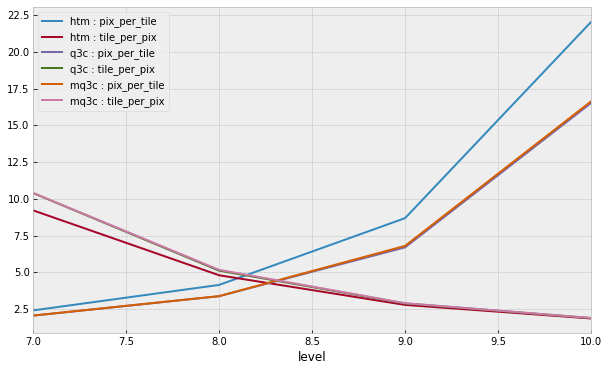

In [7]:
ax = None
for mode in ["htm", "q3c", "mq3c"]:
    mstat = stat[stat['mode']==mode].set_index('level')
    for plot in ('pix_per_tile', 'tile_per_pix'):
        ax = mstat.plot(y=plot, label=mode+' : '+plot, ax=ax, figsize=(10, 6))

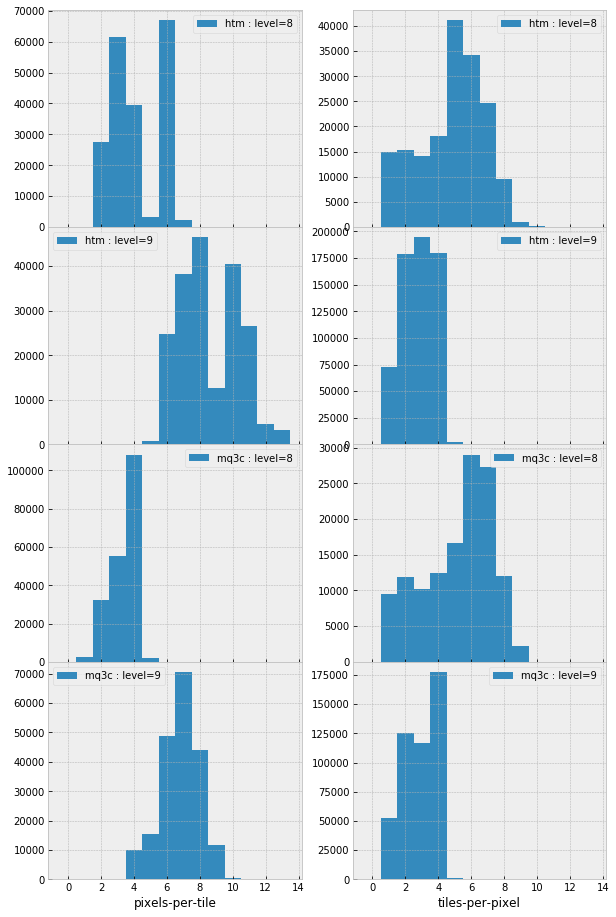

In [8]:
fig, axes = plt.subplots(4, 2, figsize=(10, 16), sharex=True)
fig.subplots_adjust(hspace=0)

idx = 0
bins = [x-0.5 for x in range(15)]
for mode in ["htm", "mq3c"]:
    for level in [8, 9]:
        for ix, plot in enumerate(['pixels-per-tile', 'tiles-per-pixel']):
            fname = f"data/DM-19536/{plot}-{mode}-{level}.dat.gz"
            arr = np.loadtxt(fname, dtype=int)
            ax = axes[idx][ix]
            ax.hist(arr, bins=bins, label=mode+" : level=" + str(level))
            ax.legend()
            ax.set_xlabel(plot)
        idx += 1

## Number of partitions

Ideal case is of course when each separate CCD in one exposure maps into a separate partition. This means that partition size that is about the same as CCD size which result in a relatively large number of partitions (~400,000 for one hemisphere). While it may be possible to have that many partitions in general it may result in a management overhead as each partition typically needs a separate set of data files (and controlling structures). If this large partition count is an issu we can conbine multiple non-neighbour partitions into a single partition, so that at small scale we still have CCD mapping to different patitions but at large scale there is a repeating pattern.

For HTM case for example there are 256 level=8 trixels inside one level=4 trixel, all of them can be given unique partition ID, which will repeat for other level=4 trixels. Similar idea should work for Q3C too (basically it means using lower 8 bits of HTM/Q3C index as partition ID).


## Timing first Cassandra test

The code is from the tip of the branch.

Partitioning and clustering:
- DiaObject - (htm8, diaObjectId, validityStart)
- DiaObjectLast - (htm8, pixelId, diaObjectId)
- Dia(Forced)Source - ((htm8, month), pixelId, midPointTai)

Testing was done in VM on my desktop which only hs one shared spinning disk, so numbers are expected to be terrible. Full FOV was processed in a single thread, a lot of CPU time is spent on building queries. For each table we only save few columns as prototype does not have code yet to fill physical quantities there. 

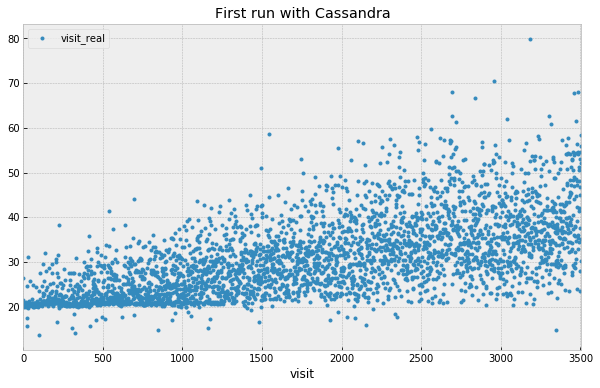

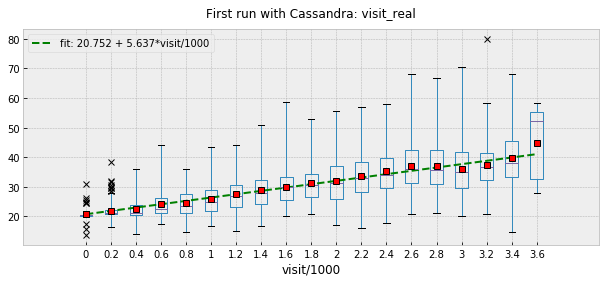

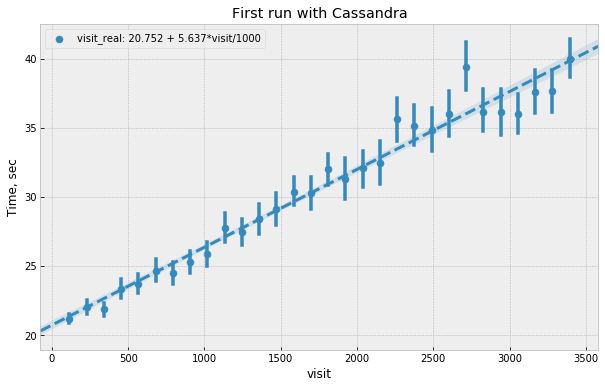

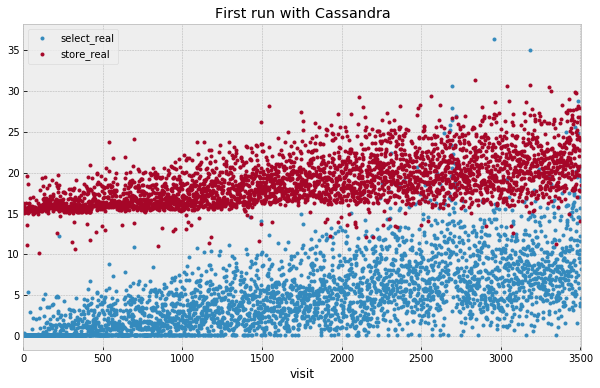

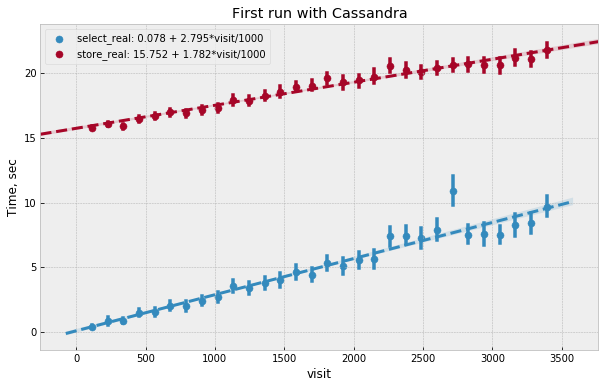

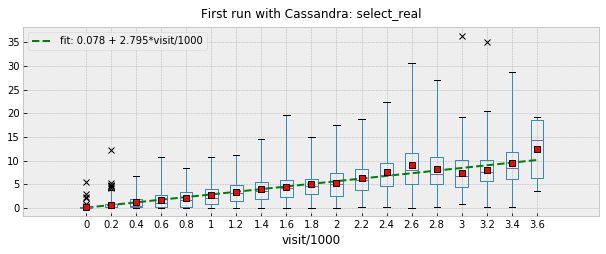

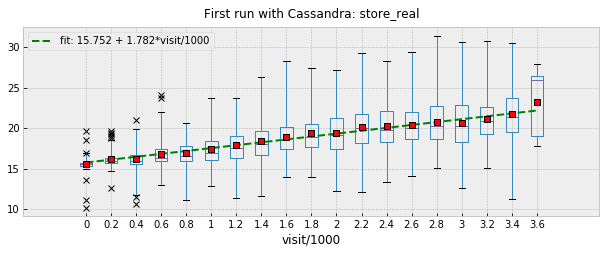

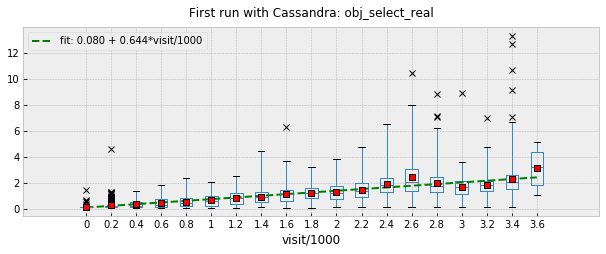

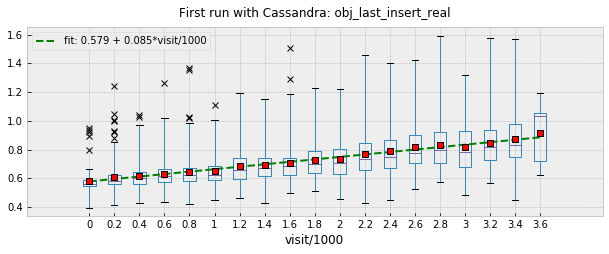

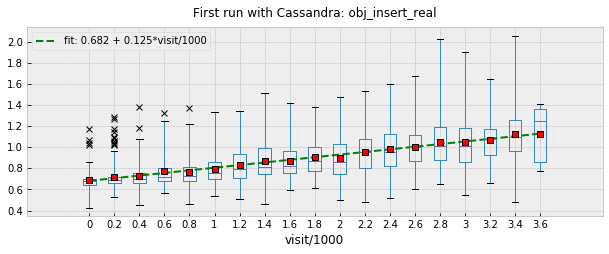

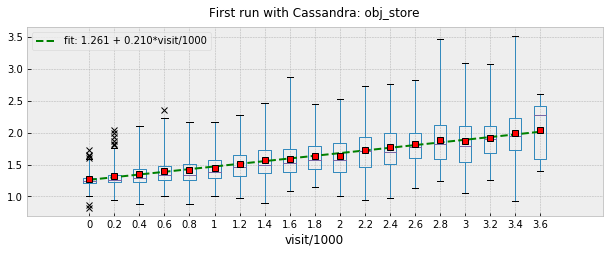

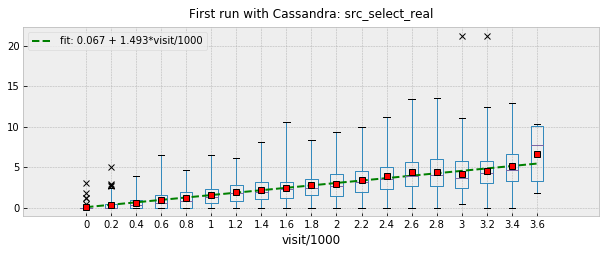

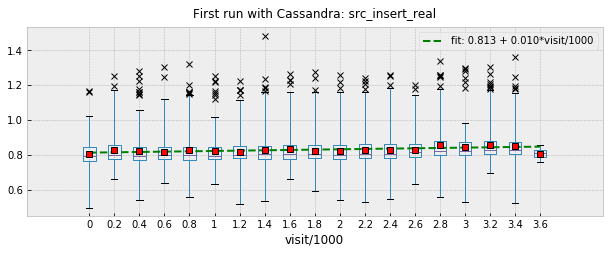

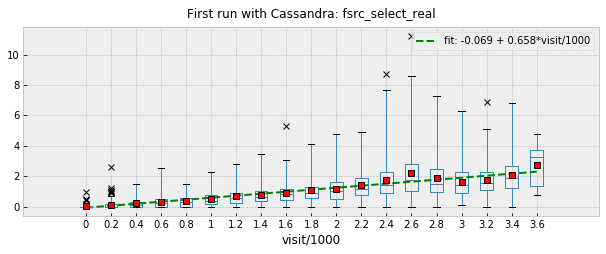

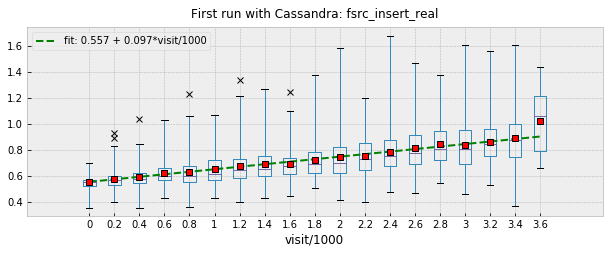

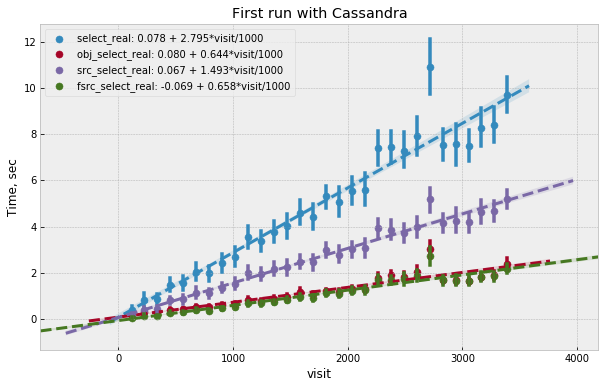

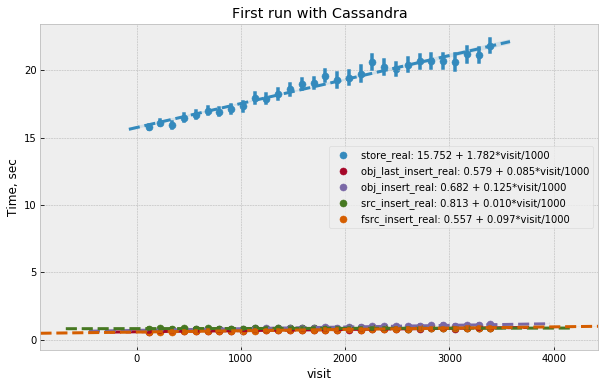

In [11]:
csv = "data/dm-19536-cassandra-first-try.csv.gz"
title = "First run with Cassandra"
ds = plots.do_plots(csv, title, bin=200, filter_count=True, whis=whiskers, what=('scatter', 'box', 'fit'))
plots.do_plots_all(ds, title, bin=200, filter_count=True, plots=all_plots, whis=whiskers);